# Auction Bot Detection

In [2]:
#Import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import boto3
import sagemaker
import json
import random
import io
from sagemaker.session import Session
from sagemaker.s3 import S3Downloader, S3Uploader
import time
from time import gmtime, strftime, sleep
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sklearn import tree, metrics
from sklearn.ensemble import GradientBoostingClassifier
from datetime import datetime, timedelta
from sagemaker import get_execution_role, image_uris
from sagemaker.clarify import (
    BiasConfig,
    DataConfig,
    ModelConfig,
    ModelPredictedLabelConfig,
    SHAPConfig,
)
from sagemaker.model import Model
from sagemaker.model_monitor import (
    BiasAnalysisConfig,
    CronExpressionGenerator,
    DataCaptureConfig,
    EndpointInput,
    ExplainabilityAnalysisConfig,
    ModelBiasMonitor,
    ModelExplainabilityMonitor,
)

from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.model_monitor import ModelQualityMonitor, EndpointInput, CronExpressionGenerator
from sagemaker.model_monitor.dataset_format import DatasetFormat
from threading import Thread

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


# S3 Datalake

In [3]:
import warnings 
warnings.filterwarnings('ignore') 

In [4]:
#View test and bid files
train_data = pd.read_csv("train.csv")
train_data['outcome'] = train_data['outcome'].astype(int)
train_data.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


In [5]:
bid_data = pd.read_csv("bids.csv")
bid_data.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [6]:
test_data = pd.read_csv("test.csv")

In [7]:
print("Bids Dataset Shape: ", bid_data.shape)
print("Train Dataset Shape: ", train_data.shape)
print("Test Dataset Shape: ", test_data.shape)

Bids Dataset Shape:  (7656334, 9)
Train Dataset Shape:  (2013, 4)
Test Dataset Shape:  (4700, 3)


In [8]:
#Setup S3 bucket and upload files 
bucket = Session().default_bucket()
region = boto3.Session().region_name
s3_client = boto3.client("s3", region_name=region)
sess = sagemaker.Session()
role = sagemaker.get_execution_role()

S3Uploader.upload("test.csv", f"s3://{bucket}/facebook-recruiting-iv-human-or-bot")
S3Uploader.upload("train.csv", f"s3://{bucket}/facebook-recruiting-iv-human-or-bot")
S3Uploader.upload("bids.csv", f"s3://{bucket}/facebook-recruiting-iv-human-or-bot")

's3://sagemaker-us-east-1-385225481548/facebook-recruiting-iv-human-or-bot/bids.csv'

# Athena Table SetUp

In [9]:
!pip install pyathena

  Using cached pyathena-3.8.3-py3-none-any.whl.metadata (6.2 kB)
Using cached pyathena-3.8.3-py3-none-any.whl (75 kB)


In [10]:
from pyathena import connect

In [11]:
#Create Athena database and S3 staging directory
database_name = "bot_bids"
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
pd.read_sql(statement, conn)

""


In [12]:
#Verify database created successfully
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(1)

,database_name
0,bot_bids


In [13]:
# SQL statement to execute
bid_table_name_csv = "bids"
s3_data_path = f"s3://{bucket}/facebook-recruiting-iv-human-or-bot/"
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         bid_id int,
         bidder_id string,
         auction string,
         merchandise string,
         device string,
         time timestamp,
         country string,
         ip string,
         url string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, bid_table_name_csv, s3_data_path
)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS bot_bids.bids(
         bid_id int,
         bidder_id string,
         auction string,
         merchandise string,
         device string,
         time timestamp,
         country string,
         ip string,
         url string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LOCATION 's3://sagemaker-us-east-1-385225481548/facebook-recruiting-iv-human-or-bot/'
TBLPROPERTIES ('skip.header.line.count'='1')


In [14]:
pd.read_sql(statement, conn)

""


In [15]:
#Verify the table is created 
statement = "SHOW TABLES in {}".format(database_name)
df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,bids


# Exploratory Data Analysis

In [16]:
#Find missing values and calculate percentage that are missing
bid_data.isnull().sum()

bid_id            0
bidder_id         0
auction           0
merchandise       0
device            0
time              0
country        8859
ip                0
url               0
dtype: int64

In [17]:
missing_percent = bid_data['country'].isnull().mean()
print(f"Percentage of missing data in country column: {missing_percent*100: .2f}%")

Percentage of missing data in country column:  0.12%


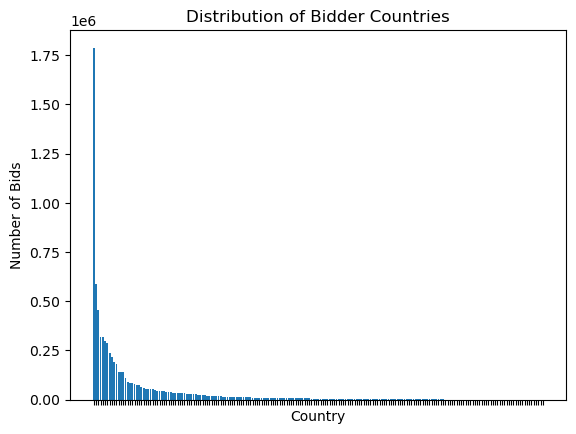

In [18]:
#Check country distribution
unique_countries = bid_data['country'].value_counts()
plt.bar(unique_countries.index, unique_countries.values)
plt.xticks(visible=False)   
plt.title("Distribution of Bidder Countries")
plt.xlabel("Country")
plt.ylabel("Number of Bids")
plt.show()

In [19]:
#Since one country has dramaticaly more bids than the others, fill the NA values with the mode
bid_data['country'] = bid_data['country'].fillna(bid_data['country'].mode()[0])

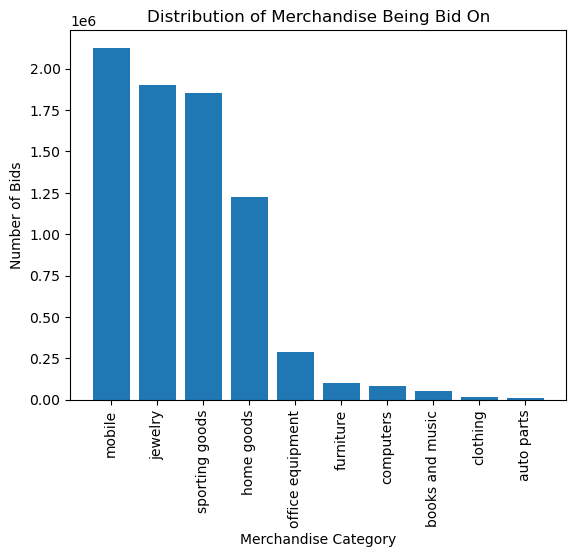

In [20]:
#Check merchandise distribution 
unique_products = bid_data['merchandise'].value_counts()
plt.bar(unique_products.index, unique_products.values)
plt.title("Distribution of Merchandise Being Bid On")
plt.xlabel("Merchandise Category")
plt.ylabel("Number of Bids")
plt.xticks(rotation=90)                    
plt.show()

In [21]:
#View distribution of bot vs human bids in training dataset
#Uneven distribution indicates oversampling will be needed
train_data['outcome'].value_counts()

outcome
0.0    1910
1.0     103
Name: count, dtype: int64

# Feature Store

In [22]:
#Setup Feature store
boto_session = boto3.Session(region_name=region)
sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

default_s3_bucket_name = feature_store_session.default_bucket()
prefix = "sagemaker-featurestore"

print(default_s3_bucket_name)

sagemaker-us-east-1-385225481548


In [23]:
# bot_bids_bucket_name = f"sagemaker-bid-bids-{region}"
bot_bids_bucket_name = default_s3_bucket_name
bids_file_key = (
    "facebook-recruiting-iv-human-or-bot/bids.csv"
)
train_file_key = (
    "facebook-recruiting-iv-human-or-bot/train.csv"
)

bids_data_object = s3_client.get_object(
    Bucket=bot_bids_bucket_name, Key=bids_file_key
)
train_data_object = s3_client.get_object(
    Bucket=bot_bids_bucket_name, Key=train_file_key
)

# Feature Engineering 

In [24]:
#Identify unique feature counts 
bidder_unique = bid_data.groupby("bidder_id").nunique().reset_index()
bidder_unique.head()

,bidder_id,bid_id,auction,merchandise,device,time,country,ip,url
0,001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,1,1
1,002d229ffb247009810828f648afc2ef593rb,2,1,1,2,2,1,1,1
2,0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1,1,1
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3,3,1,3,3,1,3,2
4,00486a11dff552c4bd7696265724ff81yeo9v,20,13,1,8,20,1,10,7


In [25]:
#Merge bid and train datasets and drop payment account and address as they provide no additional information
train_set = train_data.merge(bidder_unique, on='bidder_id', how='left').drop(columns = ['payment_account', 'address'], 
                                                                           errors = 'ignore')
train_set = train_set.rename(columns = {'bid_id': 'num_bids', 'auction': 'num_auct', 'merchandise': 'num_merch_type', 
                                        'device': 'num_device_type', 'time': 'num_time', 'country': 'num_ctry', 
                                        'ip': 'num_ip', 'url': 'num_url'})
train_set = train_set.fillna(0)
train_set.head()

,bidder_id,outcome,num_bids,num_auct,num_merch_type,num_device_type,num_time,num_ctry,num_ip,num_url
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,24.0,18.0,1.0,14.0,24.0,6.0,20.0,1.0
1,624f258b49e77713fc34034560f93fb3hu3jo,0.0,3.0,1.0,1.0,2.0,3.0,1.0,3.0,2.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,0.0,4.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,0.0,155.0,23.0,1.0,53.0,155.0,2.0,123.0,91.0


In [26]:
#Repeat for test data
test_set = test_data.merge(bidder_unique, on='bidder_id', how='left').drop(columns = ['payment_account', 'address'], 
                                                                           errors = 'ignore')
test_set = test_set.rename(columns = {'bid_id': 'num_bids', 'auction': 'num_auct', 'merchandise': 'num_merch_type', 
                                      'device': 'num_device_type', 'time': 'num_time', 'country': 'num_ctry', 
                                      'ip': 'num_ip', 'url': 'num_url'})
test_set = test_set.fillna(0)

In [27]:
print("Train Dataset Shape: ", train_set.shape)
print("Test Dataset Shape: ", test_set.shape)

Train Dataset Shape:  (2013, 10)
Test Dataset Shape:  (4700, 9)


# Feature Groups 

In [28]:
#Define feature groups
train_feature_group_name = "train-feature-group-" + strftime("%d-%H-%M-%S", gmtime())
test_feature_group_name = "test-feature-group-" + strftime("%d-%H-%M-%S", gmtime())

train_feature_group = FeatureGroup(
    name=train_feature_group_name, sagemaker_session=feature_store_session
)
test_feature_group = FeatureGroup(
    name=test_feature_group_name, sagemaker_session=feature_store_session
)

current_time_sec = int(round(time.time()))

def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == "object":
            data_frame[label] = data_frame[label].astype("str").astype("string")


# cast object dtype to string. The SageMaker FeatureStore Python SDK will then 
#map the string dtype to String feature type.
cast_object_to_string(test_set)
cast_object_to_string(train_set)

# record identifier and event time feature names
record_identifier_feature_name = "bidder_id"
event_time_feature_name = "EventTime"

# append EventTime feature
train_set[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(train_set), dtype="float64"
)
test_set[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(test_set), dtype="float64"
)

# load feature definitions to the feature group
train_feature_group.load_feature_definitions(data_frame=train_set)
test_feature_group.load_feature_definitions(data_frame=test_set)

[FeatureDefinition(feature_name='bidder_id', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None),
 FeatureDefinition(feature_name='num_bids', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='num_auct', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='num_merch_type', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='num_device_type', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='num_time', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='num_ctry', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='num_ip', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 Fea

In [29]:
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(10)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")


train_feature_group.create(
    s3_uri=f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)

test_feature_group.create(
    s3_uri=f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)

wait_for_feature_group_creation_complete(feature_group=train_feature_group)
wait_for_feature_group_creation_complete(feature_group=test_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup train-feature-group-17-22-15-15 successfully created.
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup test-feature-group-17-22-15-15 successfully created.


In [30]:
train_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:385225481548:feature-group/train-feature-group-17-22-15-15',
 'FeatureGroupName': 'train-feature-group-17-22-15-15',
 'RecordIdentifierFeatureName': 'bidder_id',
 'EventTimeFeatureName': 'EventTime',
 'FeatureDefinitions': [{'FeatureName': 'bidder_id', 'FeatureType': 'String'},
  {'FeatureName': 'outcome', 'FeatureType': 'Fractional'},
  {'FeatureName': 'num_bids', 'FeatureType': 'Fractional'},
  {'FeatureName': 'num_auct', 'FeatureType': 'Fractional'},
  {'FeatureName': 'num_merch_type', 'FeatureType': 'Fractional'},
  {'FeatureName': 'num_device_type', 'FeatureType': 'Fractional'},
  {'FeatureName': 'num_time', 'FeatureType': 'Fractional'},
  {'FeatureName': 'num_ctry', 'FeatureType': 'Fractional'},
  {'FeatureName': 'num_ip', 'FeatureType': 'Fractional'},
  {'FeatureName': 'num_url', 'FeatureType': 'Fractional'},
  {'FeatureName': 'EventTime', 'FeatureType': 'Fractional'}],
 'CreationTime': datetime.datetime(2024, 6, 17, 22, 15, 15, 3

In [31]:
#Put records into the feature group
train_feature_group.ingest(data_frame=train_set, max_workers=3, wait=True)

IngestionManagerPandas(feature_group_name='train-feature-group-17-22-15-15', feature_definitions={'bidder_id': {'FeatureName': 'bidder_id', 'FeatureType': 'String'}, 'outcome': {'FeatureName': 'outcome', 'FeatureType': 'Fractional'}, 'num_bids': {'FeatureName': 'num_bids', 'FeatureType': 'Fractional'}, 'num_auct': {'FeatureName': 'num_auct', 'FeatureType': 'Fractional'}, 'num_merch_type': {'FeatureName': 'num_merch_type', 'FeatureType': 'Fractional'}, 'num_device_type': {'FeatureName': 'num_device_type', 'FeatureType': 'Fractional'}, 'num_time': {'FeatureName': 'num_time', 'FeatureType': 'Fractional'}, 'num_ctry': {'FeatureName': 'num_ctry', 'FeatureType': 'Fractional'}, 'num_ip': {'FeatureName': 'num_ip', 'FeatureType': 'Fractional'}, 'num_url': {'FeatureName': 'num_url', 'FeatureType': 'Fractional'}, 'EventTime': {'FeatureName': 'EventTime', 'FeatureType': 'Fractional'}}, sagemaker_fs_runtime_client_config=<botocore.config.Config object at 0x7f86896b72b0>, sagemaker_session=<sagemake

In [32]:
test_feature_group.ingest(data_frame=test_set, max_workers=3, wait=True)

IngestionManagerPandas(feature_group_name='test-feature-group-17-22-15-15', feature_definitions={'bidder_id': {'FeatureName': 'bidder_id', 'FeatureType': 'String'}, 'num_bids': {'FeatureName': 'num_bids', 'FeatureType': 'Fractional'}, 'num_auct': {'FeatureName': 'num_auct', 'FeatureType': 'Fractional'}, 'num_merch_type': {'FeatureName': 'num_merch_type', 'FeatureType': 'Fractional'}, 'num_device_type': {'FeatureName': 'num_device_type', 'FeatureType': 'Fractional'}, 'num_time': {'FeatureName': 'num_time', 'FeatureType': 'Fractional'}, 'num_ctry': {'FeatureName': 'num_ctry', 'FeatureType': 'Fractional'}, 'num_ip': {'FeatureName': 'num_ip', 'FeatureType': 'Fractional'}, 'num_url': {'FeatureName': 'num_url', 'FeatureType': 'Fractional'}, 'EventTime': {'FeatureName': 'EventTime', 'FeatureType': 'Fractional'}}, sagemaker_fs_runtime_client_config=<botocore.config.Config object at 0x7f86896b72b0>, sagemaker_session=<sagemaker.session.Session object at 0x7f86a1109690>, max_workers=3, max_proce

In [33]:
#Ensure data is ingested by retrieving a record
featurestore_runtime.get_record(
    FeatureGroupName=train_feature_group_name,
    RecordIdentifierValueAsString="91a3c57b13234af24875c56fb7e2b2f4rb56a",
)

{'ResponseMetadata': {'RequestId': '8e92709b-3b5f-4a86-b0cd-7e0968503b18',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8e92709b-3b5f-4a86-b0cd-7e0968503b18',
   'content-type': 'application/json',
   'content-length': '902',
   'date': 'Mon, 17 Jun 2024 22:16:33 GMT'},
  'RetryAttempts': 0},
 'Record': [{'FeatureName': 'bidder_id',
   'ValueAsString': '91a3c57b13234af24875c56fb7e2b2f4rb56a'},
  {'FeatureName': 'outcome', 'ValueAsString': '0.0'},
  {'FeatureName': 'num_bids', 'ValueAsString': '24.0'},
  {'FeatureName': 'num_auct', 'ValueAsString': '18.0'},
  {'FeatureName': 'num_merch_type', 'ValueAsString': '1.0'},
  {'FeatureName': 'num_device_type', 'ValueAsString': '14.0'},
  {'FeatureName': 'num_time', 'ValueAsString': '24.0'},
  {'FeatureName': 'num_ctry', 'ValueAsString': '6.0'},
  {'FeatureName': 'num_ip', 'ValueAsString': '20.0'},
  {'FeatureName': 'num_url', 'ValueAsString': '1.0'},
  {'FeatureName': 'EventTime', 'ValueAsString': '1718662515.0'}]}

In [34]:
#Wait for data to be available in the offline store
account_id = boto3.client("sts").get_caller_identity()["Account"]
print(account_id)

train_feature_group_resolved_output_s3_uri = (
    train_feature_group.describe()
    .get("OfflineStoreConfig")
    .get("S3StorageConfig")
    .get("ResolvedOutputS3Uri")
)
test_feature_group_resolved_output_s3_uri = (
    test_feature_group.describe()
    .get("OfflineStoreConfig")
    .get("S3StorageConfig")
    .get("ResolvedOutputS3Uri")
)

train_feature_group_s3_prefix = train_feature_group_resolved_output_s3_uri.replace(
    f"s3://{default_s3_bucket_name}/", ""
)
test_feature_group_s3_prefix = test_feature_group_resolved_output_s3_uri.replace(
    f"s3://{default_s3_bucket_name}/", ""
)

offline_store_contents = None
while offline_store_contents is None:
    objects_in_bucket = s3_client.list_objects(
        Bucket=default_s3_bucket_name, Prefix=train_feature_group_s3_prefix
    )
    if "Contents" in objects_in_bucket and len(objects_in_bucket["Contents"]) > 1:
        offline_store_contents = objects_in_bucket["Contents"]
    else:
        print("Waiting for data in offline store...\n")
        sleep(60)

print("Data available.")

385225481548
Waiting for data in offline store...

Waiting for data in offline store...

Waiting for data in offline store...

Waiting for data in offline store...

Waiting for data in offline store...

Waiting for data in offline store...

Data available.


# Split Data

In [50]:
#Due to train set only containing labels, it is split into train:test:validation 80:10:10
#Test set with no labels is reserved for production data
rand_split = np.random.rand(len(train_set))
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = rand_split >= 0.9

#the bidder_id is not a training feature
data_train = train_set[train_list].drop(["bidder_id"], axis=1)
data_val = train_set[val_list].drop(["bidder_id"], axis=1)
data_test1 = train_set[test_list].drop(["bidder_id"], axis=1)
data_test = train_set[test_list].drop(["outcome"], axis=1)
data_test_outcome = train_set[test_list]["outcome"]
data_test_noID = data_test.drop(["bidder_id"], axis=1)

data_prod = test_set

In [88]:
#Upload files into S3
train_file = "train_data.csv"
data_train.to_csv(train_file, index=False, header=False)
sess.upload_data(train_file, key_prefix="{}/train".format(prefix))

train_file_with_header = "train_data_with_header.csv"
data_train.to_csv(train_file_with_header, index=False, header=True)
sess.upload_data(train_file_with_header, key_prefix="{}/train".format(prefix))

validation_file = "validation_data.csv"
data_val.to_csv(validation_file, index=False, header=False)
sess.upload_data(validation_file, key_prefix="{}/validation".format(prefix))

validation_file_with_header = "validation_data_with_header.csv"
data_val.to_csv(validation_file_with_header, index=False, header=True)
sess.upload_data(validation_file_with_header, key_prefix="{}/validation".format(prefix))

test_file = "test_data.csv"
data_test.to_csv(test_file, index=False, header=False)
sess.upload_data(test_file, key_prefix="{}/test".format(prefix))

test_file_with_header = "test_data_with_header.csv"
data_test.to_csv(test_file_with_header, index=False, header=True)
sess.upload_data(test_file_with_header, key_prefix="{}/test".format(prefix))

test_file_with_outcome = "test_data_with_outcome.csv"
data_test1.to_csv(test_file_with_outcome, index=False, header=False)
sess.upload_data(test_file_with_outcome, key_prefix="{}/test".format(prefix))

test_file_noID = "test_data_noID.csv"
data_test_noID.to_csv(test_file_noID, index=False, header=False)
sess.upload_data(test_file_noID, key_prefix="{}/test".format(prefix))

test_file_outcome = "test_data_outcome.csv"
data_test_outcome.to_csv(test_file_outcome, index=False, header=False)
sess.upload_data(test_file_outcome, key_prefix="{}/test".format(prefix))

prod_file = "prod_data.csv"
data_prod.to_csv(prod_file, index=False, header=False)
sess.upload_data(prod_file, key_prefix="{}/prod".format(prefix))

's3://sagemaker-us-east-1-385225481548/sagemaker-featurestore/prod/prod_data.csv'

In [37]:
s3_train_data = f"s3://{bucket}/{prefix}/train/"
s3_test_data = f"s3://{bucket}/{prefix}/test/"
s3_val_data = f"s3://{bucket}/{prefix}/validation/"
s3_prod_data = f"s3://{bucket}/{prefix}/prod/"

# Decision Tree Model Bench Mark

In [38]:
#Create dataframes for model training
train_df = pd.read_csv(s3_train_data+"train_data_with_header.csv")
val_df = pd.read_csv(s3_val_data+"validation_data_with_header.csv")

In [39]:
#Build basic decision tree and predict on the validation set
#Evaluate the model 
clf = tree.DecisionTreeClassifier(max_depth=3, criterion='entropy')
clf.fit(train_df.drop(columns=["outcome"]), train_df["outcome"])
pred_val = clf.predict(val_df.drop(columns=["outcome"])) 

fpr, tpr, thresholds = metrics.roc_curve(val_df['outcome'],pred_val)

print("The AUC score for the decision tree model is: ", metrics.auc(fpr, tpr))
print(metrics.classification_report(val_df['outcome'],pred_val))

The AUC score for the decision tree model is:  0.5
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       203
         1.0       0.00      0.00      0.00        12

    accuracy                           0.94       215
   macro avg       0.47      0.50      0.49       215
weighted avg       0.89      0.94      0.92       215



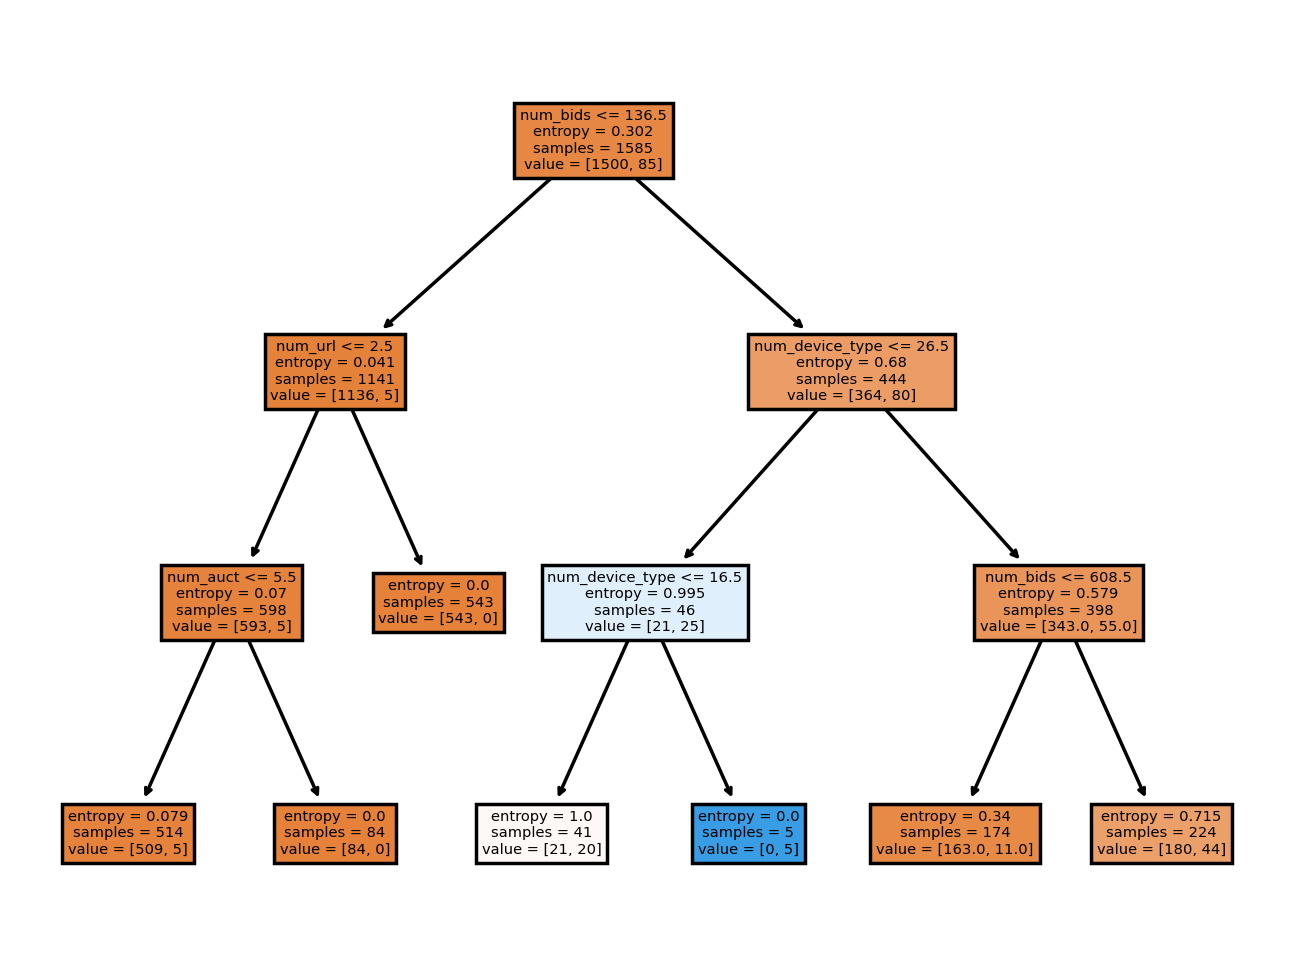

In [40]:
#Visualizing the Tree
plt.rcParams['figure.dpi'] = 250
f_names=list(train_df.drop(columns=["outcome"]).columns)
tree.plot_tree(clf, filled=True, feature_names=f_names)
plt.show()

# Initial XGBoost Model

In [41]:
#Build basic gradient boosted model and predict on the validation set
#Evaluate the model 
gbc = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, random_state=0)
gbc.fit(train_df.drop(columns=["outcome"]), train_df["outcome"])
pred_val = gbc.predict(val_df.drop(columns=["outcome"])) 

fpr, tpr, thresholds = metrics.roc_curve(val_df['outcome'],pred_val)

print("The AUC score for the decision tree model is: ", metrics.auc(fpr, tpr))
print(metrics.classification_report(val_df['outcome'],pred_val))

The AUC score for the decision tree model is:  0.529351395730706
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       203
         1.0       0.17      0.08      0.11        12

    accuracy                           0.93       215
   macro avg       0.56      0.53      0.54       215
weighted avg       0.90      0.93      0.91       215



# Training XGBOOST

In [42]:
#Training the xgb algorithm with data
job_name = "xgb-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_location = "s3://{}/{}/output/{}".format(bucket, prefix, job_name)
image = sagemaker.image_uris.retrieve(
    framework="xgboost", region=boto3.Session().region_name, version="1.7-1"
)

sm_estimator = sagemaker.estimator.Estimator(
    image,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size=50,
    input_mode="File",
    output_path=output_location,
    sagemaker_session=sess,
    rules=[
        Rule.sagemaker(rule_configs.create_xgboost_report()),
        ProfilerRule.sagemaker(rule_configs.ProfilerReport())
    ]
)

sm_estimator.set_hyperparameters(
    max_depth=3,
    num_round=100,
)
train_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "train/train_data.csv"),content_type="text/csv"
)
validation_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "validation/validation_data.csv"),content_type="text/csv"
)
data_channels = {"train": train_data, "validation": validation_data}

# Start training by calling the fit method in the estimator
sm_estimator.fit(inputs=data_channels, job_name=job_name, logs=False)

INFO:sagemaker:Creating training-job with name: xgb-2024-06-17-22-22-37



2024-06-17 22:22:43 Starting - Starting the training job..
2024-06-17 22:22:55 Starting - Preparing the instances for training....
2024-06-17 22:23:23 Downloading - Downloading input data....
2024-06-17 22:23:45 Downloading - Downloading the training image.......
2024-06-17 22:24:25 Training - Training image download completed. Training in progress...
2024-06-17 22:24:43 Uploading - Uploading generated training model.
2024-06-17 22:24:53 Completed - Training job completed


# Model Quality Monitor

In [44]:
#Create prefixes
s3_key = f"s3://{bucket}/{prefix}"
s3_capture_upload_path = f"{s3_key}/datacapture"
ground_truth_upload_path = f"{s3_key}/ground_truth_data/{datetime.now():%Y-%m-%d-%H-%M-%S}"
s3_report_path = f"{s3_key}/reports"

print(f"Capture path: {s3_capture_upload_path}")
print(f"Ground truth path: {ground_truth_upload_path}")
print(f"Report path: {s3_report_path}")

baseline_results_uri = f"{s3_key}/baselining"
print(f"Baseline results uri: {baseline_results_uri}")

endpoint_instance_count = 1
endpoint_instance_type = "ml.m4.xlarge"
schedule_expression = CronExpressionGenerator.hourly()

Capture path: s3://sagemaker-us-east-1-385225481548/sagemaker-featurestore/datacapture
Ground truth path: s3://sagemaker-us-east-1-385225481548/sagemaker-featurestore/ground_truth_data/2024-06-17-22-25-38
Report path: s3://sagemaker-us-east-1-385225481548/sagemaker-featurestore/reports
Baseline results uri: s3://sagemaker-us-east-1-385225481548/sagemaker-featurestore/baselining


In [45]:
#Define model and files 
model_url = "s3://{}/{}/output/{}/{}/output/model.tar.gz".format(bucket, prefix, job_name, job_name)
# test_dataset = "test_data/test-dataset-input-cols.csv"
validation_dataset = "validation_data_with_header.csv"
dataset_type = "text/csv"

with open(validation_dataset) as f:
    headers_line = f.readline().rstrip()
all_headers = headers_line.split(",")
label_header = all_headers[0]

In [46]:
#Create a model from the file on S3
model_name = f"bids-model-monitor-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("Model name: ", model_name)
endpoint_name = f"bids-model-monitor-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("Endpoint name: ", endpoint_name)

Model name:  bids-model-monitor-2024-06-17-2226
Endpoint name:  bids-model-monitor-2024-06-17-2226


In [47]:
#Deploy with data capture enabled
model = Model(
    role=role,
    name=model_name,
    image_uri=image,
    model_data=model_url,
    sagemaker_session=sess,
)

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=s3_capture_upload_path,
)
print(f"Deploying model {model_name} to endpoint {endpoint_name}")
model.deploy(
    initial_instance_count=endpoint_instance_count,
    instance_type=endpoint_instance_type,
    endpoint_name=endpoint_name,
    data_capture_config=data_capture_config,
)

INFO:sagemaker:Creating model with name: bids-model-monitor-2024-06-17-2226


Deploying model bids-model-monitor-2024-06-17-2226 to endpoint bids-model-monitor-2024-06-17-2226


INFO:sagemaker:Creating endpoint-config with name bids-model-monitor-2024-06-17-2226
INFO:sagemaker:Creating endpoint with name bids-model-monitor-2024-06-17-2226


-------!

In [48]:
#Create predictor object
predictor = Predictor(
    endpoint_name=endpoint_name, sagemaker_session=sess, serializer=CSVSerializer()
)

In [62]:
#Create baseline with 0.8 as the cut off value
bids_cutoff = 0.8
validate_dataset = "validation_data_predictions.csv"

In [89]:
limit = 200
i = 0
with open(f"{validate_dataset}", "w") as baseline_file:
    baseline_file.write("probability,prediction,label\n")  # our header
    with open("validation_data.csv", "r") as f:
        for row in f:
            (label, input_cols) = row.split(",", 1)
            probability = float(predictor.predict(input_cols))
            prediction = "1" if probability > bids_cutoff else "0"
            baseline_file.write(f"{probability},{prediction},{label}\n")
            i += 1
            if i > limit:
                break
            print(".", end="", flush=True)
            sleep(0.5)
print()
print("Done!")

........................................................................................................................................................................................................
Done!


In [90]:
#View predicitons
!head validation_data_predictions.csv

probability,prediction,label
0.0012788178864866495,0,0
0.006682614330202341,0,0
0.006496461108326912,0,0
0.0028278296813368797,0,0
-7.713999366387725e-06,0,0
0.010264449752867222,0,0
-0.0009272203897126019,0,0
-0.0018974218983203173,0,0
-0.0010146322892978787,0,0


In [65]:
#Upload predictions as a baseline
baseline_prefix = prefix + "/baselining"
baseline_data_prefix = baseline_prefix + "/data"
baseline_results_prefix = baseline_prefix + "/results"

baseline_data_uri = f"s3://{bucket}/{baseline_data_prefix}"
baseline_results_uri = f"s3://{bucket}/{baseline_results_prefix}"
print(f"Baseline data uri: {baseline_data_uri}")
print(f"Baseline results uri: {baseline_results_uri}")

Baseline data uri: s3://sagemaker-us-east-1-385225481548/sagemaker-featurestore/baselining/data
Baseline results uri: s3://sagemaker-us-east-1-385225481548/sagemaker-featurestore/baselining/results


In [91]:
baseline_dataset_uri = S3Uploader.upload(f"{validate_dataset}", baseline_data_uri)
baseline_dataset_uri

's3://sagemaker-us-east-1-385225481548/sagemaker-featurestore/baselining/data/validation_data_predictions.csv'

In [68]:
# Create the model quality monitoring object
bids_model_quality_monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=sess,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [92]:
# Name of the model quality baseline job
baseline_job_name = f"xgb-bids-model-baseline-job-{datetime.utcnow():%Y-%m-%d-%H%M}"

In [93]:
# Execute the baseline suggestion job.
job = bids_model_quality_monitor.suggest_baseline(
    job_name=baseline_job_name,
    baseline_dataset=baseline_dataset_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    problem_type="BinaryClassification",
    inference_attribute="prediction",
    probability_attribute="probability",
    ground_truth_attribute="label",
)
job.wait(logs=False)

INFO:sagemaker:Creating processing-job with name xgb-bids-model-baseline-job-2024-06-17-2333


...........................................................!

In [94]:
baseline_job = bids_model_quality_monitor.latest_baselining_job

In [95]:
#See the baseline statistics 
binary_metrics = baseline_job.baseline_statistics().body_dict["binary_classification_metrics"]
pd.json_normalize(binary_metrics).T

,0
confusion_matrix.0.0,193
confusion_matrix.0.1,0
confusion_matrix.1.0,4
confusion_matrix.1.1,4
recall.value,0.5
recall.standard_deviation,0.05466
precision.value,1.0
precision.standard_deviation,0.0
accuracy.value,0.9801
accuracy.standard_deviation,0.003328


In [96]:
pd.DataFrame(baseline_job.suggested_constraints().body_dict["binary_classification_constraints"]).T

,threshold,comparison_operator
recall,0.5,LessThanThreshold
precision,1.0,LessThanThreshold
accuracy,0.9801,LessThanThreshold
true_positive_rate,0.5,LessThanThreshold
true_negative_rate,1.0,LessThanThreshold
false_positive_rate,0.0,GreaterThanThreshold
false_negative_rate,0.5,GreaterThanThreshold
auc,0.963083,LessThanThreshold
f0_5,0.833333,LessThanThreshold
f1,0.666667,LessThanThreshold


In [101]:
#Generate prediction data
def invoke_endpoint(ep_name, file_name):
    with open(file_name, "r") as f:
        i = 0
        for row in f:
            payload = row.rstrip("\n")
            response = sess.sagemaker_runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType="text/csv",
                Body=payload,
                InferenceId=str(i),  # unique ID per row
            )["Body"].read()
            i += 1
            sleep(1)


def invoke_endpoint_forever():
    while True:
        try:
            invoke_endpoint(endpoint_name, "test_data_noID.csv")
        except sess.sagemaker_runtime_client.exceptions.ValidationError:
            pass


thread = Thread(target=invoke_endpoint_forever)
thread.start()

In [102]:
#Generate synthetic ground truth
def ground_truth_with_id(inference_id):
    random.seed(inference_id)  # to get consistent results
    rand = random.random()
    return {
        "groundTruthData": {
            "data": "1" if rand < 0.7 else "0",  # randomly generate positive labels 70% of the time
            "encoding": "CSV",
        },
        "eventMetadata": {
            "eventId": str(inference_id),
        },
        "eventVersion": "0",
    }


def upload_ground_truth(records, upload_time):
    fake_records = [json.dumps(r) for r in records]
    data_to_upload = "\n".join(fake_records)
    target_s3_uri = f"{ground_truth_upload_path}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
    print(f"Uploading {len(fake_records)} records to", target_s3_uri)
    S3Uploader.upload_string_as_file_body(data_to_upload, target_s3_uri)

In [104]:
NUM_GROUND_TRUTH_RECORDS = 334  # 334 are the number of rows in data we're sending for inference
def generate_fake_ground_truth_forever():
    j = 0
    while True:
        fake_records = [ground_truth_with_id(i) for i in range(NUM_GROUND_TRUTH_RECORDS)]
        upload_ground_truth(fake_records, datetime.utcnow())
        j = (j + 1) % 5
        sleep(60 * 60)  # do this once an hour


gt_thread = Thread(target=generate_fake_ground_truth_forever)
gt_thread.start()

Uploading 334 records to s3://sagemaker-us-east-1-385225481548/sagemaker-featurestore/ground_truth_data/2024-06-17-22-25-38/2024/06/17/23/4214.jsonl
Uploading 334 records to s3://sagemaker-us-east-1-385225481548/sagemaker-featurestore/ground_truth_data/2024-06-17-22-25-38/2024/06/18/00/4214.jsonl


In [105]:
##Monitoring schedule name
bids_monitor_schedule_name = (
    f"xgb-bids-monitoring-schedule-{datetime.utcnow():%Y-%m-%d-%H%M}"
)

In [106]:
# Create an enpointInput
endpointInput = EndpointInput(
    endpoint_name=predictor.endpoint_name,
    probability_attribute="0",
    probability_threshold_attribute=0.5,
    destination="/opt/ml/processing/input_data",
)

In [108]:
# Create the monitoring schedule to execute every hour.
response = bids_model_quality_monitor.create_monitoring_schedule(
    monitor_schedule_name=bids_monitor_schedule_name,
    endpoint_input=endpointInput,
    output_s3_uri=baseline_results_uri,
    problem_type="BinaryClassification",
    ground_truth_input=ground_truth_upload_path,
    constraints=baseline_job.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: xgb-bids-monitoring-schedule-2024-06-17-2342


In [110]:
# Create the monitoring schedule
# You will see the monitoring schedule in the 'Scheduled' status
bids_model_quality_monitor.describe_schedule()

{'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:385225481548:monitoring-schedule/xgb-bids-monitoring-schedule-2024-06-17-2342',
 'MonitoringScheduleName': 'xgb-bids-monitoring-schedule-2024-06-17-2342',
 'MonitoringScheduleStatus': 'Scheduled',
 'MonitoringType': 'ModelQuality',
 'CreationTime': datetime.datetime(2024, 6, 17, 23, 42, 44, 413000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 6, 17, 23, 42, 50, 726000, tzinfo=tzlocal()),
 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 * ? * * *)'},
  'MonitoringJobDefinitionName': 'model-quality-job-definition-2024-06-17-23-42-43-829',
  'MonitoringType': 'ModelQuality'},
 'EndpointName': 'bids-model-monitor-2024-06-17-2226',
 'ResponseMetadata': {'RequestId': '0336eaa1-6351-4ca4-b471-cf1107aa4563',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '0336eaa1-6351-4ca4-b471-cf1107aa4563',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '602',
   'da

In [112]:
# Initially there will be no executions since the first execution happens at the top of the hour
# Note that it is common for the execution to luanch upto 20 min after the hour.
executions = bids_model_quality_monitor.list_executions()
executions

[]

In [114]:
# Wait for the first execution of the monitoring_schedule
print("Waiting for first execution", end="")
while True:
    execution = bids_model_quality_monitor.describe_schedule().get(
        "LastMonitoringExecutionSummary"
    )
    if execution:
        break
    print(".", end="", flush=True)
    sleep(10)
print()
print("Execution found!")

Waiting for first execution.................................................................................................................................
Execution found!


In [115]:
while not executions:
    executions = bids_model_quality_monitor.list_executions()
    sleep(10)
latest_execution = executions[-1]
latest_execution.describe()

{'ProcessingInputs': [{'InputName': 'groundtruth_input_1',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-385225481548/sagemaker-featurestore/ground_truth_data/2024-06-17-22-25-38/2024/06/17/23',
    'LocalPath': '/opt/ml/processing/groundtruth/2024/06/17/23',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'endpoint_input_1',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-385225481548/sagemaker-featurestore/datacapture/bids-model-monitor-2024-06-17-2226/AllTraffic/2024/06/17/23',
    'LocalPath': '/opt/ml/processing/input_data/bids-model-monitor-2024-06-17-2226/AllTraffic/2024/06/17/23',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'result',
    'S3Output': {'S3Uri': 's3://sa

In [117]:
status = execution["MonitoringExecutionStatus"]

while status in ["Pending", "InProgress"]:
    print("Waiting for execution to finish", end="")
    latest_execution.wait(logs=False)
    latest_job = latest_execution.describe()
    print()
    print(f"{latest_job['ProcessingJobName']} job status:", latest_job["ProcessingJobStatus"])
    print(
        f"{latest_job['ProcessingJobName']} job exit message, if any:",
        latest_job.get("ExitMessage"),
    )
    print(
        f"{latest_job['ProcessingJobName']} job failure reason, if any:",
        latest_job.get("FailureReason"),
    )
    sleep(
        30
    )  # model quality executions consist of two Processing jobs, wait for second job to start
    latest_execution = bids_model_quality_monitor.list_executions()[-1]
    execution = bids_model_quality_monitor.describe_schedule()["LastMonitoringExecutionSummary"]
    status = execution["MonitoringExecutionStatus"]

print("Execution status is:", status)

if status != "Completed":
    print(execution)
    print(
        "====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures."
    )

Waiting for execution to finish!
groundtruth-merge-202406180000-846dd3c19ac54059056855b8 job status: Completed
groundtruth-merge-202406180000-846dd3c19ac54059056855b8 job exit message, if any: None
groundtruth-merge-202406180000-846dd3c19ac54059056855b8 job failure reason, if any: None
Waiting for execution to finish....................!
model-quality-monitoring-202406180000-846dd3c19ac54059056855b8 job status: Completed
model-quality-monitoring-202406180000-846dd3c19ac54059056855b8 job exit message, if any: CompletedWithViolations: Job completed successfully with 10 violations.
model-quality-monitoring-202406180000-846dd3c19ac54059056855b8 job failure reason, if any: None
Execution status is: CompletedWithViolations
{'MonitoringScheduleName': 'xgb-bids-monitoring-schedule-2024-06-17-2342', 'ScheduledTime': datetime.datetime(2024, 6, 18, 0, 0, tzinfo=tzlocal()), 'CreationTime': datetime.datetime(2024, 6, 18, 0, 5, 1, 419000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2024

In [118]:
latest_execution = bids_model_quality_monitor.list_executions()[-1]
report_uri = latest_execution.describe()["ProcessingOutputConfig"]["Outputs"][0]["S3Output"][
    "S3Uri"
]
print("Report Uri:", report_uri)

Report Uri: s3://sagemaker-us-east-1-385225481548/sagemaker-featurestore/baselining/results/bids-model-monitor-2024-06-17-2226/xgb-bids-monitoring-schedule-2024-06-17-2342/2024/06/18/00


In [ ]:
# Create CloudWatch client
cw_client = boto3.Session().client("cloudwatch")

namespace = "aws/sagemaker/Endpoints/model-metrics"

cw_dimensions = [
    {"Name": "Endpoint", "Value": endpoint_name},
    {"Name": "MonitoringSchedule", "Value": bids_monitor_schedule_name},
]

In [ ]:
# List metrics through the pagination interface
paginator = cw_client.get_paginator("list_metrics")

for response in paginator.paginate(Dimensions=cw_dimensions, Namespace=namespace):
    model_quality_metrics = response["Metrics"]
    for metric in model_quality_metrics:
        print(metric["MetricName"])

# Data Quality Monitor

# Cleanup Resources

In [ ]:
churn_model_quality_monitor.delete_monitoring_schedule()
sleep(60)  # actually wait for the deletion

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()

In [ ]:
invoke_endpoint_thread.terminate()
ground_truth_thread.terminate()

In [ ]:
train_feature_group.delete()
test_feature_group.delete()
sagemaker.delete_endpoint(EndpointName=endpoint_name)

# References

In [ ]:
https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_model_monitor/model_quality/model_quality_churn_sdk.html#3.1-Execute-predictions-using-the-validation-dataset.